In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay

# Load the processed dataset
data = pd.read_csv('Desktop/laptopData_PROCESSED.csv')

# Separate features and target
X_final = data.drop(columns=['Price'])
y_final = data['Price']

# Final Gradient Boosting Model with tuned hyperparameters
final_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

# Retrain on full processed dataset
final_model.fit(X_final, y_final)

print("✅ Final Gradient Boosting Model retrained on full dataset.")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


✅ Final Gradient Boosting Model retrained on full dataset.


In [2]:
# Evaluate model on full training data
y_pred = final_model.predict(X_final)

# Calculate RMSE and R^2
rmse = np.sqrt(mean_squared_error(y_final, y_pred))
r2 = r2_score(y_final, y_pred)

print(f"✅ Final Model Performance on Full Dataset:")
print(f"RMSE: {rmse:.2f}")
print(f"R^2 Score: {r2:.4f}")

✅ Final Model Performance on Full Dataset:
RMSE: 6282.57
R^2 Score: 0.9376


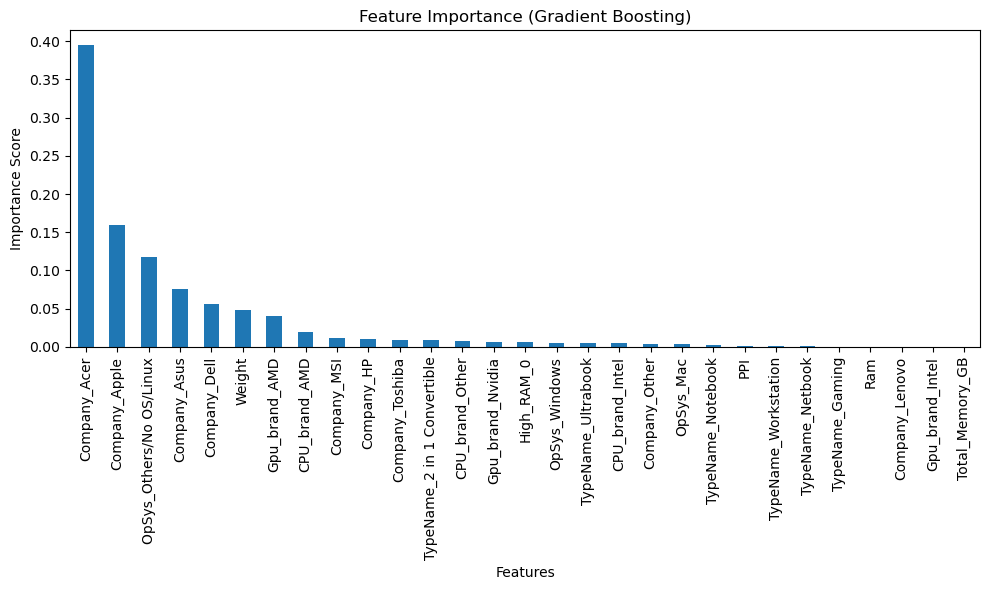

In [3]:
# Get feature importances
importances = final_model.feature_importances_

# Match feature names
feature_names = X_final.columns

# Create a DataFrame for easy sorting
feat_importances = pd.Series(importances, index=feature_names)
feat_importances = feat_importances.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
feat_importances.plot(kind='bar')
plt.title('Feature Importance (Gradient Boosting)')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.tight_layout()
plt.show()

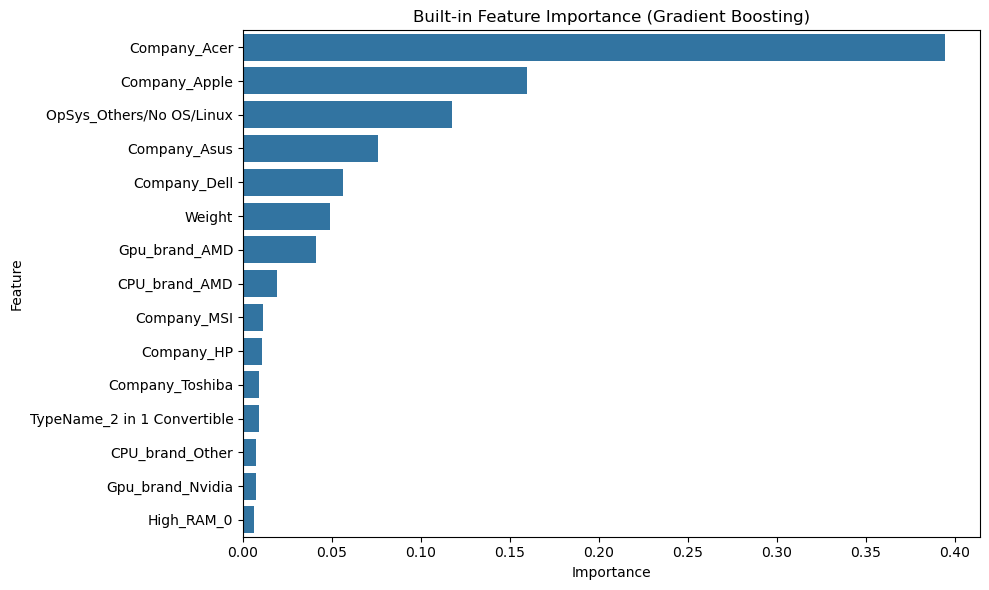

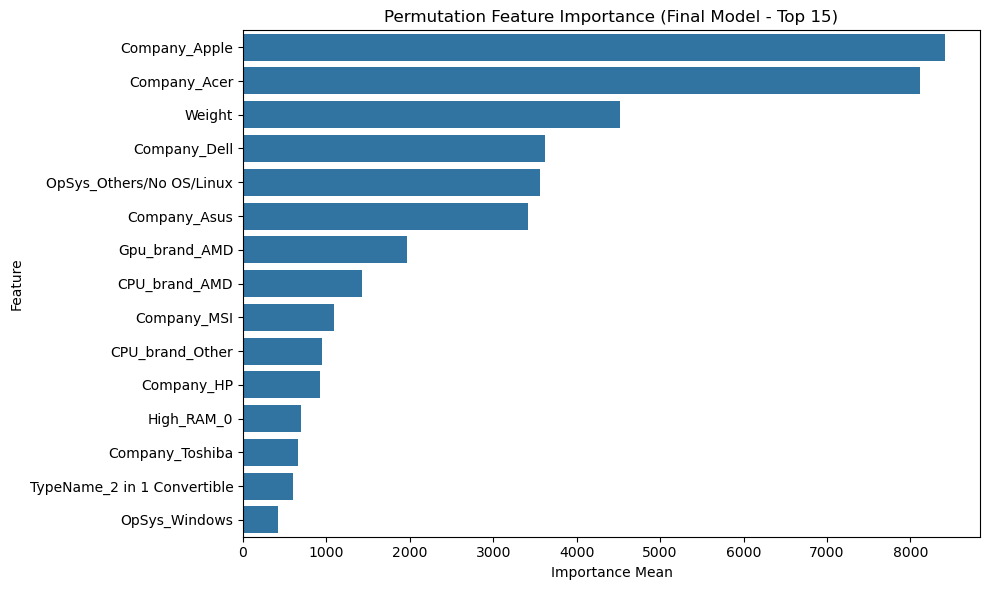

Top 5 Features (Permutation Importance):


,Feature,Importance Mean,Importance Std
1,Company_Apple,8414.545405,247.575857
0,Company_Acer,8112.977622,403.576219
26,Weight,4514.907610,245.618356
3,Company_Dell,3617.545635,225.436014
16,OpSys_Others/No OS/Linux,3555.541114,225.907615


In [4]:
# Built-in importance from the model
importances = final_model.feature_importances_
feature_names = X_final.columns

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top 15
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title('Built-in Feature Importance (Gradient Boosting)')
plt.tight_layout()
plt.show()

# Permutation importance on final_model
perm_result = permutation_importance(
    final_model,
    X_final,
    y_final,
    n_repeats=30,
    random_state=42,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

# Build a DataFrame
perm_df = pd.DataFrame({
    'Feature': X_final.columns,
    'Importance Mean': perm_result.importances_mean,
    'Importance Std': perm_result.importances_std
}).sort_values(by='Importance Mean', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance Mean', y='Feature', data=perm_df.head(15))
plt.title('Permutation Feature Importance (Final Model - Top 15)')
plt.tight_layout()
plt.show()

# Print top 5
print("Top 5 Features (Permutation Importance):")
display(perm_df.head(5))

✅ Top features selected for PDP: ['Company_Apple', 'Company_Acer', 'Weight', 'Company_Dell']


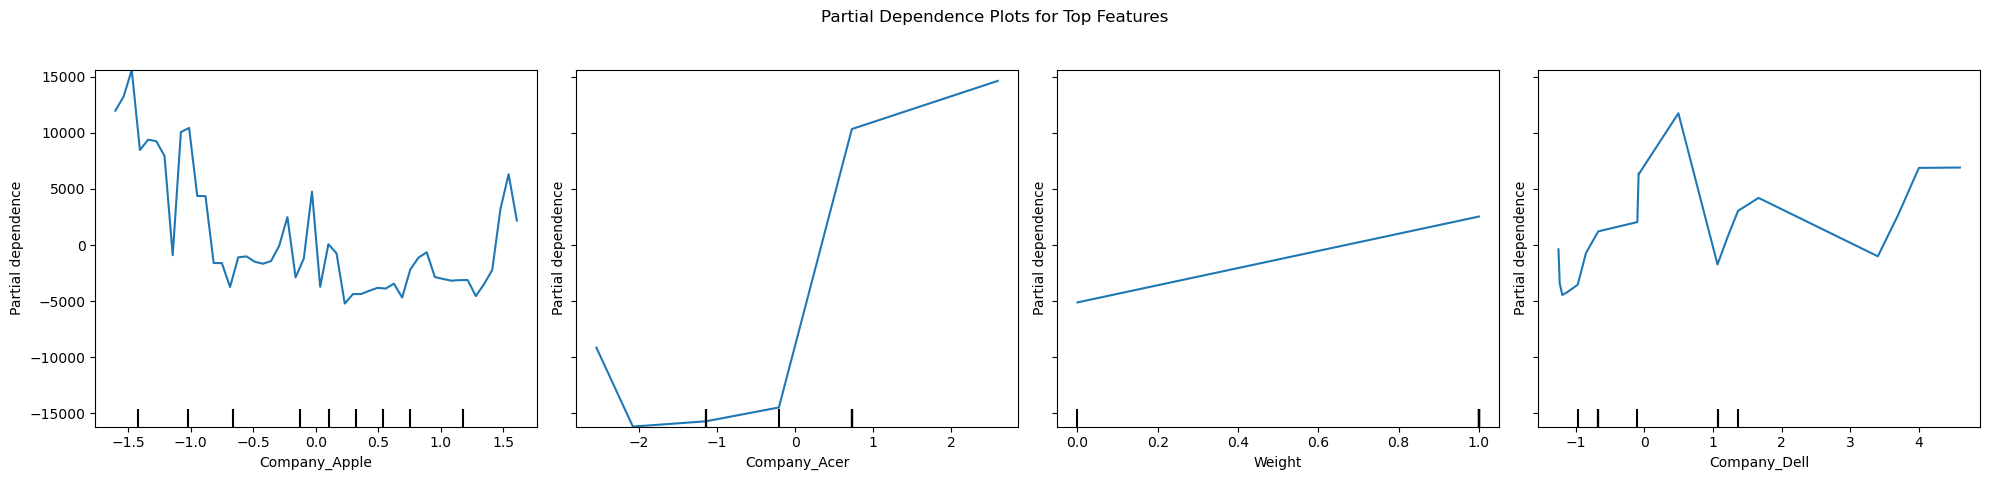

In [5]:
# Choose the top features
top_features = perm_df['Feature'].head(4).tolist()

print(f"✅ Top features selected for PDP: {top_features}")

# Plot 1-way PDPs for top features
fig, ax = plt.subplots(ncols=len(top_features), figsize=(5 * len(top_features), 5), sharey=True)

PartialDependenceDisplay.from_estimator(
    final_model,
    X_final,
    features=top_features,
    ax=ax,
    grid_resolution=50,
    n_jobs=-1
)

fig.suptitle('Partial Dependence Plots for Top Features')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

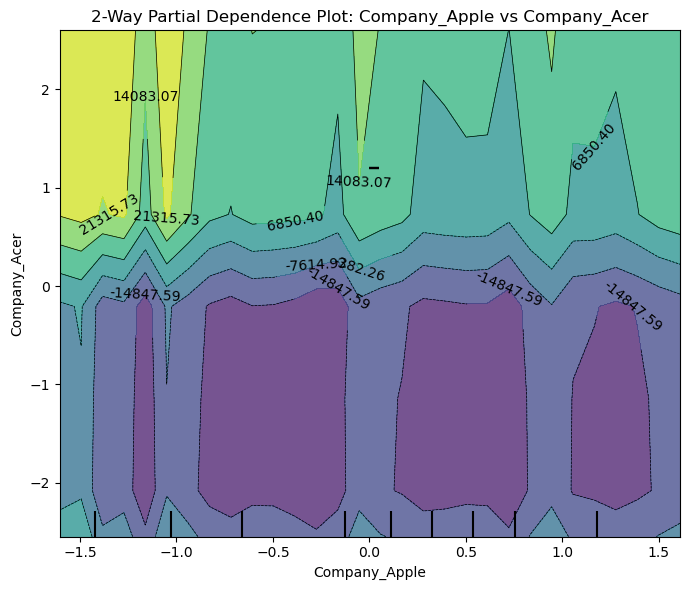

In [6]:
# Pick top 2 features
top_two_features = (top_features[0], top_features[1])

# Plot 2-way PDP
fig, ax = plt.subplots(figsize=(7, 6))

PartialDependenceDisplay.from_estimator(
    final_model,
    X_final,
    features=[top_two_features],
    ax=ax,
    grid_resolution=30,
    n_jobs=-1
)

plt.title(f'2-Way Partial Dependence Plot: {top_two_features[0]} vs {top_two_features[1]}')
plt.tight_layout()
plt.show()

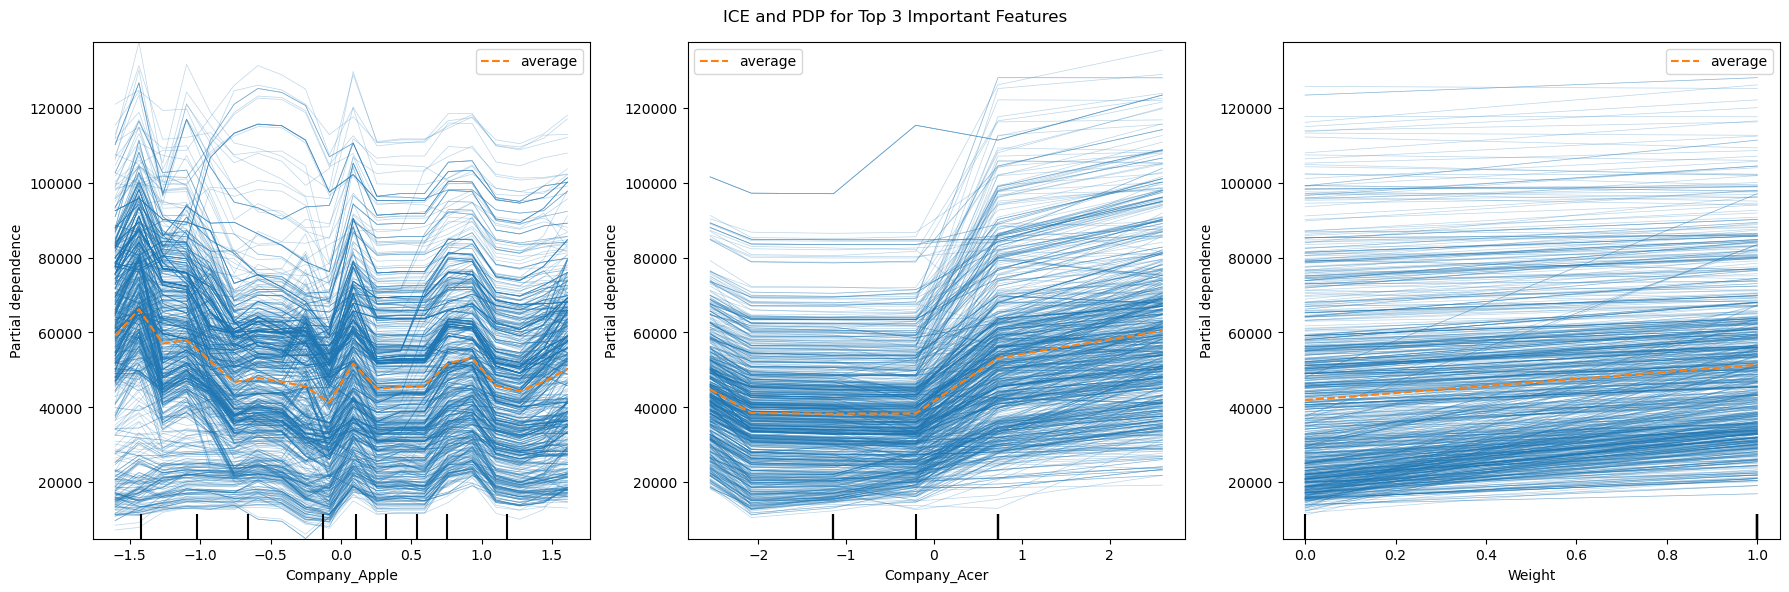

In [7]:
# Top features to visualize with ICE
top_features = ['Company_Apple', 'Company_Acer', 'Weight']

# Plotting
fig, ax = plt.subplots(ncols=3, figsize=(18, 6))

PartialDependenceDisplay.from_estimator(
    final_model,
    X_final,
    features=top_features,
    kind='both',
    ax=ax,
    grid_resolution=20
)

fig.suptitle('ICE and PDP for Top 3 Important Features')
plt.tight_layout()
plt.show()

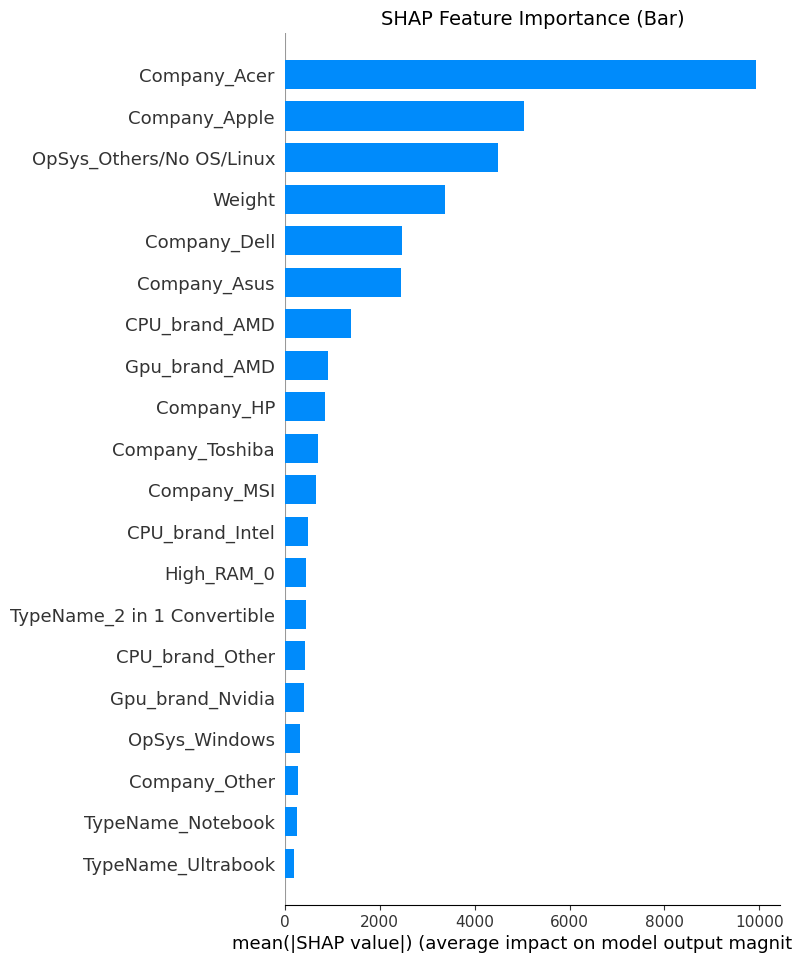

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


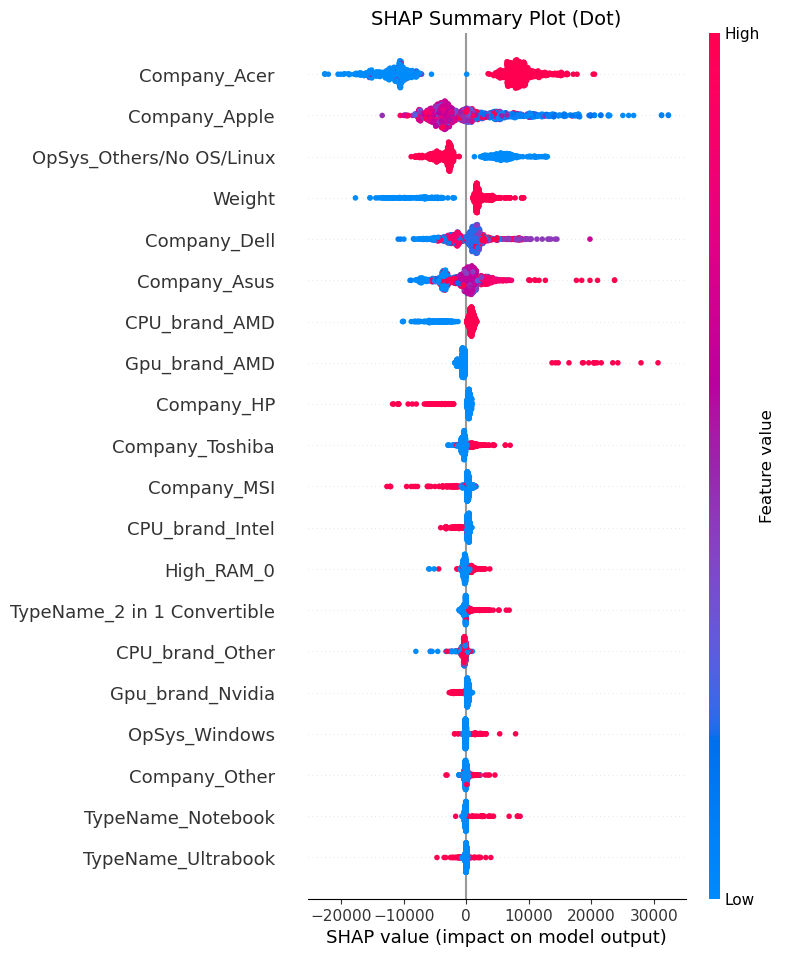

Most important feature for dependence plot: Company_Acer


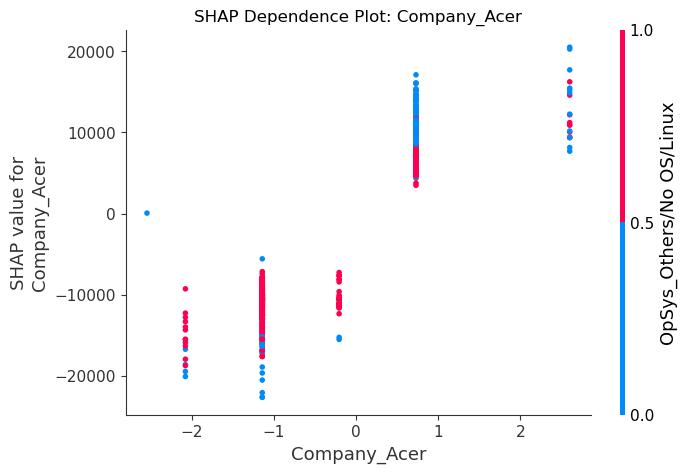

In [8]:
# Create SHAP explainer
explainer = shap.TreeExplainer(final_model)

# Sample the dataset for speed
X_sample = X_final.sample(n=1000, random_state=42) if len(X_final) > 1000 else X_final

# Compute SHAP values
shap_values = explainer.shap_values(X_sample)

# If multi-output model, take the first output
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# --- SHAP SUMMARY PLOTS ---

# Bar plot
shap.summary_plot(shap_values, X_sample, plot_type='bar', show=False)
plt.title('SHAP Feature Importance (Bar)', fontsize=14)
plt.show()

# Beeswarm plot
shap.summary_plot(shap_values, X_sample, show=False)
plt.title('SHAP Summary Plot (Dot)', fontsize=14)
plt.show()

# --- SHAP DEPENDENCE PLOT ---

# Find the most important feature (based on mean absolute SHAP)
most_important = X_sample.columns[np.argsort(np.abs(shap_values).mean(axis=0))[-1]]
print(f"Most important feature for dependence plot: {most_important}")

# Plot SHAP dependence plot for that feature
shap.dependence_plot(
    most_important,
    shap_values,
    X_sample,
    interaction_index='auto',
    show=False
)
plt.title(f'SHAP Dependence Plot: {most_important}')
plt.show()